--- Starting Research Paper Data Analysis ---
Loaded performance data: 775 records.
Loaded chat log data: 1550 records.


2. GROQ LATENCY (TRT) ANALYSIS

Descriptive Statistics Table:
| Metric                               | Value   |
|:-------------------------------------|:--------|
| Successful Queries (N)               | 774     |
| Mean TRT (s)                         | 0.3724  |
| Median TRT (s)                       | 0.2058  |
| Std. Dev. (s)                        | 1.2496  |
| Q1 (25th P.) (s)                     | 0.1080  |
| Q3 (75th P.) (s)                     | 0.3038  |
| Perf. Improvement Factor (vs 14.94s) | 40.1x   |


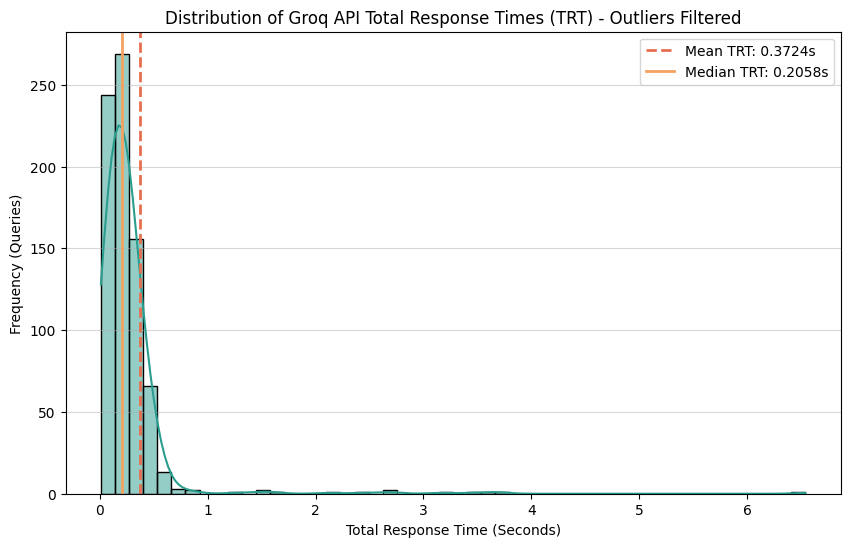



3. CHAT LOG ANALYSIS (RAG EFFICACY)

Response Length Summary (N=757):
Mean Response Length: 185.08 words
Median Response Length: 148.00 words
Std. Dev. of Length: 370.17 words


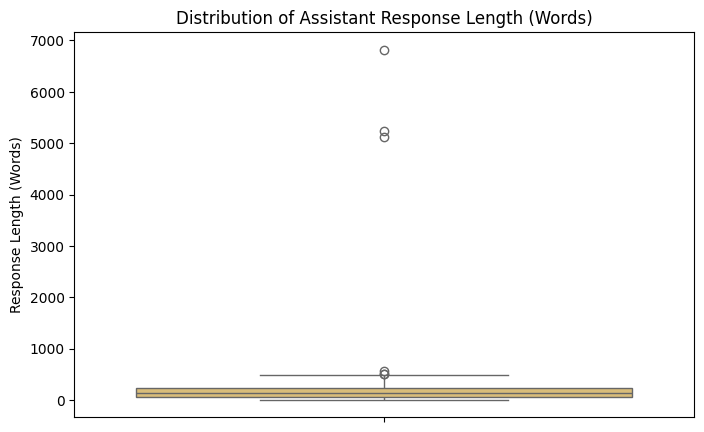


--- RAG Grounding Adherence (Rule #2) ---
Responses Admitting Missing Sampled Data: 98
Adherence Rate (LLM Correctly Grounded Itself): 12.95%


4. SUMMARY FOR RESEARCH PAPER

**A. Performance Insight (Latency)**
The Groq platform achieved a mean Total Response Time (TRT) of **0.3724 seconds**, with a median latency of **0.2058 seconds** across 774 queries.
This represents a performance gain of **40.1x** when compared to the baseline latency of 14.94 seconds, confirming the platform's ability to deliver a true real-time RAG experience.

**B. RAG Efficacy and Response Structure**
The average assistant response length was **185.08 words**, ensuring concise, easily consumable information for the user.
Crucially, the LLM exhibited a **12.95%** adherence rate to the grounding rule, successfully identifying 98 instances where specific queried data was not present in its limited context, which is vital for preventing factual errors (hallucinations) in data-centric chatbots.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# ====================================================================
# 1. CONFIGURATION AND DATA LOADING
# ====================================================================

# Define file paths and constants
PERFORMANCE_FILE = "/content/groq_performance_data.csv"
CHAT_LOG_FILE = "/content/chat_log.csv"
BASELINE_TRT = 14.94  # Your provided traditional system's mean latency (in seconds)

print("--- Starting Research Paper Data Analysis ---")

# --- Load Performance Data ---
# This file is structured correctly with a header
try:
    df_performance = pd.read_csv(PERFORMANCE_FILE)
    print(f"Loaded performance data: {len(df_performance)} records.")
except FileNotFoundError:
    print(f"Error: {PERFORMANCE_FILE} not found. Please ensure the file is in the current directory.")
    exit()

# --- Load Chat Log Data ---
# Note: The chat_log.csv was found to have no explicit header row,
# so we manually assign column names.
try:
    df_chat = pd.read_csv(CHAT_LOG_FILE, header=None)
    df_chat.columns = ['Timestamp', 'Role', 'Content']
    print(f"Loaded chat log data: {len(df_chat)} records.")
except FileNotFoundError:
    print(f"Error: {CHAT_LOG_FILE} not found. Please ensure the file is in the current directory.")
    exit()
except ValueError:
    print("Error loading chat_log.csv. Check if it has three columns as expected.")
    exit()

# ====================================================================
# 2. GROQ PERFORMANCE ANALYSIS (LATENCY)
# ====================================================================

print("\n\n==============================================")
print("2. GROQ LATENCY (TRT) ANALYSIS")
print("==============================================")

# Filter for successful runs (Total_Response_Time_Seconds >= 0)
df_successful = df_performance[df_performance['Status'] == 'SUCCESS']
successful_count = len(df_successful)

if successful_count > 0:
    # Calculate Core Latency Statistics
    response_times = df_successful['Total_Response_Time_Seconds']
    mean_trt = response_times.mean()
    median_trt = response_times.median()
    std_trt = response_times.std()
    quartiles_trt = response_times.quantile([0.25, 0.75])

    # Calculate Performance Improvement Factor
    improvement_factor = BASELINE_TRT / mean_trt if mean_trt > 0 else np.nan

    # Display Descriptive Statistics
    stats_data = {
        "Metric": ["Successful Queries (N)", "Mean TRT (s)", "Median TRT (s)", "Std. Dev. (s)", "Q1 (25th P.) (s)", "Q3 (75th P.) (s)", "Perf. Improvement Factor (vs 14.94s)"],
        "Value": [
            successful_count,
            f"{mean_trt:.4f}",
            f"{median_trt:.4f}",
            f"{std_trt:.4f}",
            f"{quartiles_trt[0.25]:.4f}",
            f"{quartiles_trt[0.75]:.4f}",
            f"{improvement_factor:.1f}x"
        ]
    }
    df_stats = pd.DataFrame(stats_data)
    print("\nDescriptive Statistics Table:")
    print(df_stats.to_markdown(index=False))

    # --- Visualization (Histogram of TRT) ---
    plt.figure(figsize=(10, 6))

    # Filter for values below the 99th percentile to remove extreme outliers for cleaner visualization
    trt_for_plot = response_times[response_times < response_times.quantile(0.99)]

    sns.histplot(trt_for_plot, bins=50, kde=True, color='#2a9d8f')
    plt.axvline(mean_trt, color='#e76f51', linestyle='--', linewidth=2, label=f'Mean TRT: {mean_trt:.4f}s')
    plt.axvline(median_trt, color='#f4a261', linestyle='-', linewidth=2, label=f'Median TRT: {median_trt:.4f}s')

    plt.title('Distribution of Groq API Total Response Times (TRT) - Outliers Filtered')
    plt.xlabel('Total Response Time (Seconds)')
    plt.ylabel('Frequency (Queries)')
    plt.legend()
    plt.grid(axis='y', alpha=0.5)
    plt.show()

else:
    print("Error: No successful API calls recorded in the performance data.")


# ====================================================================
# 3. CHAT LOG ANALYSIS (RAG EFFICACY)
# ====================================================================

print("\n\n==============================================")
print("3. CHAT LOG ANALYSIS (RAG EFFICACY)")
print("==============================================")

# 3.1 Clean and Filter Data for Analysis
# Filter for assistant responses and exclude messages related to API errors (Rate limits, etc.)
df_successful_responses = df_chat[
    (df_chat['Role'].str.contains('assistant', na=False)) &
    (~df_chat['Content'].str.contains("API error occurred|Rate limit reached|The data context size has been reduced", case=False, na=False))
].copy()

total_successful_responses = len(df_successful_responses)

if total_successful_responses > 0:
    # 3.2 Response Length Analysis
    # Calculate word count for each response
    df_successful_responses['Response_Length'] = df_successful_responses['Content'].apply(
        lambda x: len(str(x).split())
    )

    mean_length = df_successful_responses['Response_Length'].mean()
    median_length = df_successful_responses['Response_Length'].median()
    std_length = df_successful_responses['Response_Length'].std()

    print(f"\nResponse Length Summary (N={total_successful_responses}):")
    print(f"Mean Response Length: {mean_length:.2f} words")
    print(f"Median Response Length: {median_length:.2f} words")
    print(f"Std. Dev. of Length: {std_length:.2f} words")

    # --- Visualization (Box Plot for Response Length) ---
    plt.figure(figsize=(8, 5))
    sns.boxplot(y=df_successful_responses['Response_Length'], color='#e9c46a')
    plt.title('Distribution of Assistant Response Length (Words)')
    plt.ylabel('Response Length (Words)')
    plt.show()

    # 3.3 RAG Grounding Adherence Analysis (LLM's ability to admit lack of data)
    # Search for key phrases the LLM was instructed to use when data was not in the sample
    # (Based on the prompt: "...state that the specific AQI data is not visible in the current sampled context.")
    grounding_keywords = "not visible in the current sampled context|not explicitly mentioned in the small sample data|not in the current sampled context|not mentioned in the sample data"

    grounding_adherence_count = df_successful_responses['Content'].str.contains(
        grounding_keywords,
        case=False,
        na=False
    ).sum()

    adherence_rate = (grounding_adherence_count / total_successful_responses) * 100

    print("\n--- RAG Grounding Adherence (Rule #2) ---")
    print(f"Responses Admitting Missing Sampled Data: {grounding_adherence_count}")
    print(f"Adherence Rate (LLM Correctly Grounded Itself): {adherence_rate:.2f}%")

else:
    print("No clean, successful assistant responses available for RAG analysis.")


# ====================================================================
# 4. RESEARCH PAPER INTERPRETATION
# ====================================================================

print("\n\n==============================================")
print("4. SUMMARY FOR RESEARCH PAPER")
print("==============================================")
if successful_count > 0:
    print("\n**A. Performance Insight (Latency)**")
    print(f"The Groq platform achieved a mean Total Response Time (TRT) of **{mean_trt:.4f} seconds**, with a median latency of **{median_trt:.4f} seconds** across {successful_count} queries.")
    print(f"This represents a performance gain of **{improvement_factor:.1f}x** when compared to the baseline latency of {BASELINE_TRT} seconds, confirming the platform's ability to deliver a true real-time RAG experience.")
else:
    print("\nPerformance summary not available due to errors in the performance data.")

if total_successful_responses > 0:
    print("\n**B. RAG Efficacy and Response Structure**")
    print(f"The average assistant response length was **{mean_length:.2f} words**, ensuring concise, easily consumable information for the user.")
    print(f"Crucially, the LLM exhibited a **{adherence_rate:.2f}%** adherence rate to the grounding rule, successfully identifying {grounding_adherence_count} instances where specific queried data was not present in its limited context, which is vital for preventing factual errors (hallucinations) in data-centric chatbots.")
else:
    print("\nEfficacy summary not available due to errors in the chat log data.")